In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oetils.plotting import init_plotting
from tqdm.notebook import trange

In [2]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [3]:
W = init_plotting()

---

# Exercise 8.4

In [3]:
grid = np.zeros((6, 9))
grid[2, 1:] = 1
start = (0, 3)
goal = (5, 8)

In [4]:
def step(s, a):
    y, x = s
    x += (-1 if a == 3 else 1 if a == 1 else 0)
    y += (-1 if a == 2 else 1 if a == 0 else 0)
    if x < 0 or x > 8 or y < 0 or y > 5 or grid[y, x] == 1:
        return s, 0
    elif (y, x) == goal:
        return (y, x), 1
    return (y, x), 0

In [5]:
rng = np.random.default_rng(42)
N = 10_000
n = 50
eps = 0.1
alpha = 0.5
gamma = 0.95
s = start
Q = np.zeros((*grid.shape, 4))
model = {}
for i in trange(N):
    a = rng.choice(np.flatnonzero(Q[s] == Q[s].max()) if rng.uniform() > eps else 4)
    s_, r = step(s, a)
    model[(s, a)] = (s_, r)
    Q[s][a] += alpha * (r + gamma*Q[s_].max() - Q[s][a])
    s = s_ if r == 0 else start
    for j in range(n):
        k = rng.choice(len(model.keys()))
        x, u = list(model.keys())[k]
        x_, r = model[(x, u)]
        Q[x][u] += alpha * (r + gamma*Q[x_].max() - Q[x][u])

  0%|          | 0/10000 [00:00<?, ?it/s]

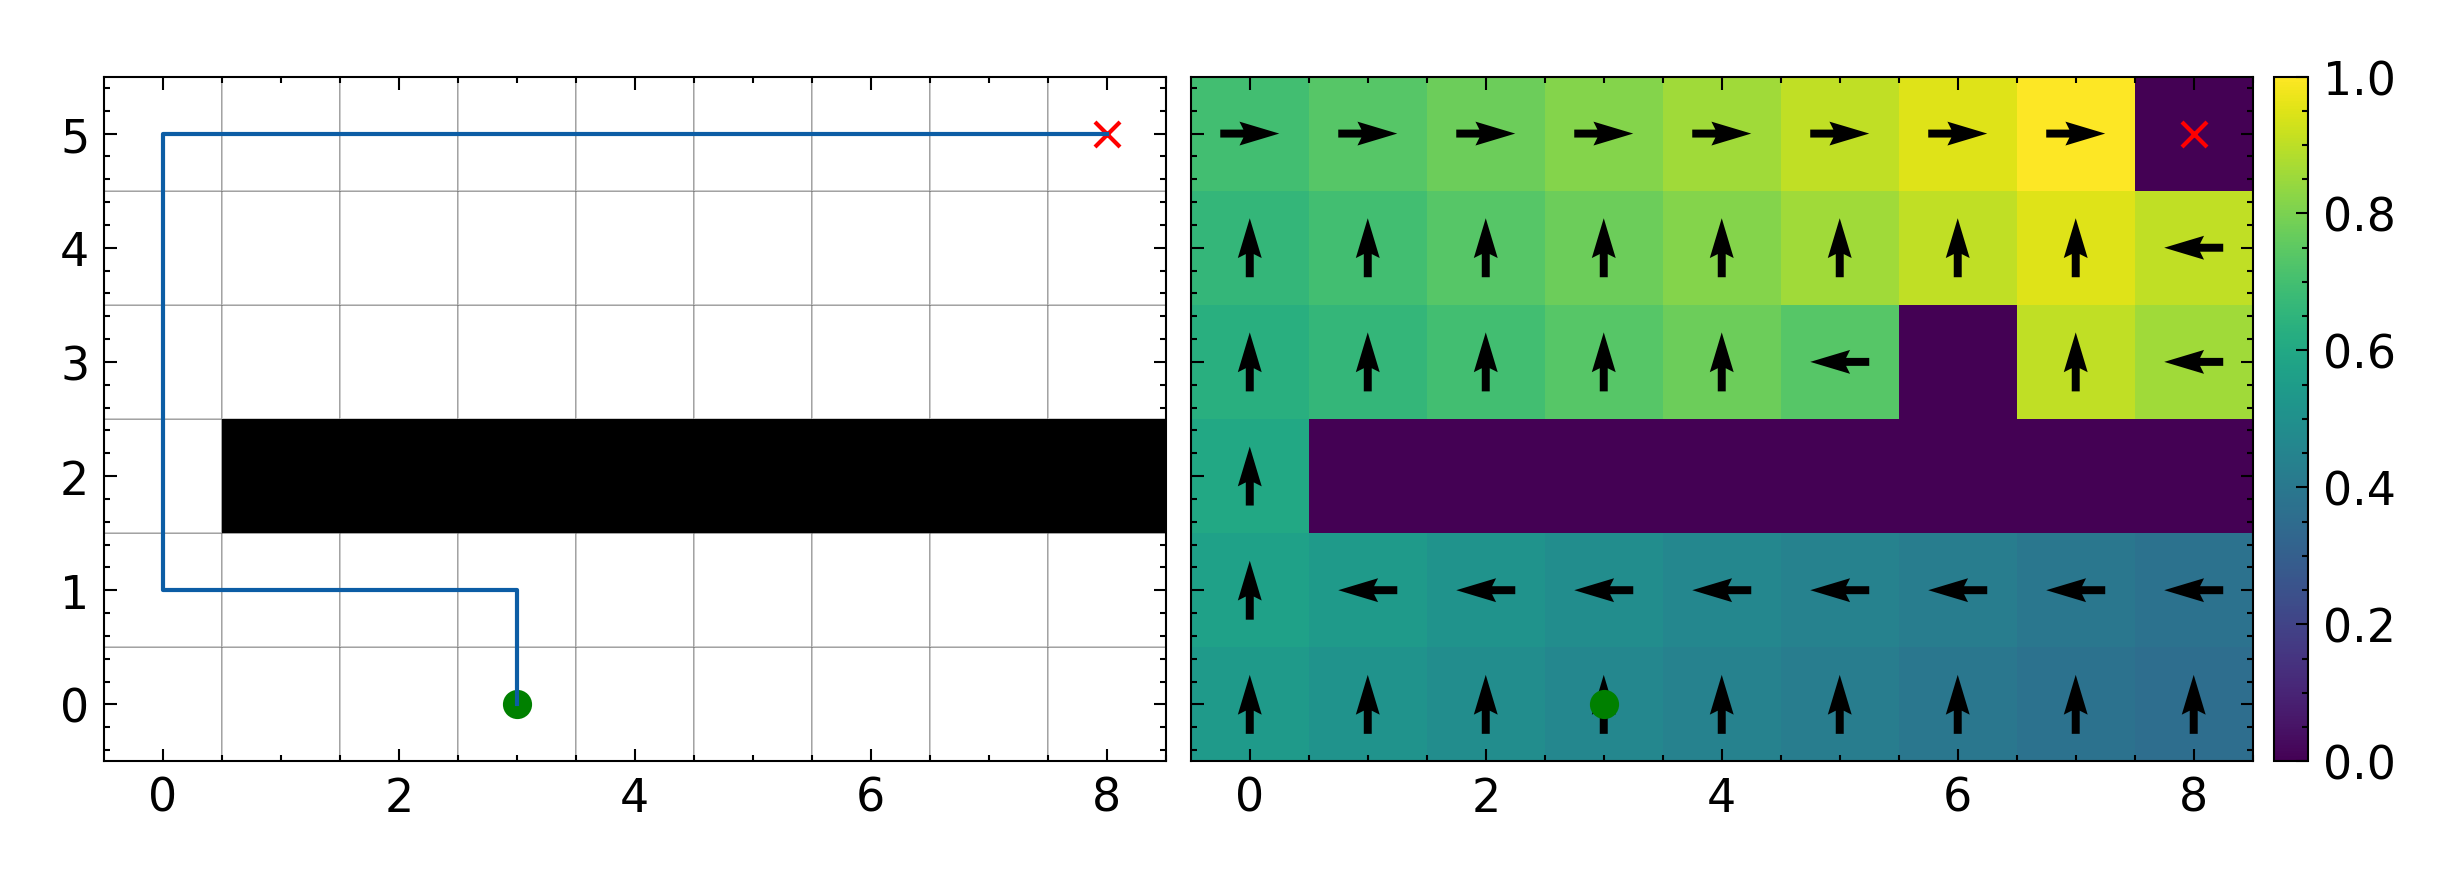

In [6]:
plt.rcParams["axes.axisbelow"] = 'line'
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(W, W/3))
ax[0].pcolormesh(np.arange(grid.shape[1]), np.arange(grid.shape[0]), -grid, cmap='gray',
                 edgecolors=(0, 0, 0, 0.2), linewidth=0.1)
ax[0].plot(start[1], start[0], 'go')
ax[0].plot(goal[1], goal[0], 'rx')
ax[0].grid(False)

# Plot solution
s = start
ep = [s]
while True:
    a = np.argmax(Q[s])
    s, r = step(s, a)
    ep.append(s)
    if r == 1: break
ep = np.array(ep)
ax[0].plot(ep[:, 1], ep[:, 0])

# Plot value function
I = ax[1].pcolormesh(np.arange(grid.shape[1]), np.arange(grid.shape[0]), Q.max(-1), cmap='viridis')
fig.colorbar(I, pad=0.02)
ax[1].plot(start[1], start[0], 'go')
ax[1].plot(goal[1], goal[0], 'rx')
ax[1].grid(False)
for x in range(9):
    for y in range(6):
        if Q[y, x].max() == 0: continue
        a = np.argmax(Q[y, x])
        u = -1 if a == 3 else 1 if a == 1 else 0
        v = -1 if a == 2 else 1 if a == 0 else 0
        ax[1].quiver([x], [y], [u], [v], pivot='mid')

# Non-stationary dynamics

In [11]:
start = (0, 3)
goal = (5, 8)
N = 3000
M = 1000
n = 50
eps = 0.1
alpha = 0.5
gamma = 0.95

Q_dyna = np.zeros((*grid.shape, 4))
R_dyna = np.zeros(N)
for seed in trange(10):
    grid = np.zeros((6, 9))
    grid[2, :-1] = 1
    rng = np.random.default_rng(seed)
    s = start
    Q = np.zeros((*grid.shape, 4))
    model = {}
    R = np.zeros(N)
    for i in trange(N, leave=False):
        if i == M:
            grid = np.zeros((6, 9))
            grid[2, 1:] = 1
        a = rng.choice(np.flatnonzero(Q[s] == Q[s].max()) if rng.uniform() > eps else 4)
        s_, r = step(s, a)
        R[i] = r
        model[(s, a)] = (s_, r)
        Q[s][a] += alpha * (r + gamma*Q[s_].max() - Q[s][a])
        s = s_ if r == 0 else start
        for j in range(n):
            k = rng.choice(len(model.keys()))
            x, u = list(model.keys())[k]
            x_, r = model[(x, u)]
            Q[x][u] += alpha * (r + gamma*Q[x_].max() - Q[x][u])
    R_dyna += np.cumsum(R)
    Q_dyna += Q

R_dyna /= 10
Q_dyna /= 10

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [12]:
kappa = 1e-4

Q_dynap = np.zeros((*grid.shape, 4))
R_dynap = np.zeros(N)
for seed in trange(10):
    grid = np.zeros((6, 9))
    grid[2, :-1] = 1
    rng = np.random.default_rng(seed)
    s = start
    Q = np.zeros((*grid.shape, 4))
    T = np.zeros((*grid.shape, 4))
    model = {}
    R = np.zeros(N)
    for i in trange(N, leave=False):
        if i == M:
            grid = np.zeros((6, 9))
            grid[2, 1:] = 1
        a = rng.choice(np.flatnonzero(Q[s] == Q[s].max()) if rng.uniform() > eps else 4)
        s_, r = step(s, a)
        R[i] = r
        T += 1
        T[s][a] = 0
        model[(s, a)] = (s_, r)
        Q[s][a] += alpha * (r + gamma*Q[s_].max() - Q[s][a])
        s = s_ if r == 0 else start
        for j in range(n):
            k = rng.choice(len(model.keys()))
            x, _ = list(model.keys())[k]
            u = rng.choice(4)
            x_, r = model[(x, u)] if (x, u) in model else (x, 0)
            r += kappa * np.sqrt(T[x][u])
            Q[x][u] += alpha * (r + gamma*Q[x_].max() - Q[x][u])
    R_dynap += np.cumsum(R)
    Q_dynap += Q

R_dynap /= 10
Q_dynap /= 10

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [13]:
Q_dynap2 = np.zeros((*grid.shape, 4))
R_dynap2 = np.zeros(N)
for seed in trange(10):
    grid = np.zeros((6, 9))
    grid[2, :-1] = 1
    rng = np.random.default_rng(seed)
    s = start
    Q = np.zeros((*grid.shape, 4))
    T = np.zeros((*grid.shape, 4))
    model = {}
    R = np.zeros(N)
    for i in trange(N, leave=False):
        if i == M:
            grid = np.zeros((6, 9))
            grid[2, 1:] = 1
        Qs = Q[s] + kappa*T[s]
        a = rng.choice(np.flatnonzero(Qs == Qs.max()) if rng.uniform() > eps else 4)
        s_, r = step(s, a)
        R[i] = r
        T += 1
        T[s][a] = 0
        model[(s, a)] = (s_, r)
        Q[s][a] += alpha * (r + gamma*Q[s_].max() - Q[s][a])
        s = s_ if r == 0 else start
        for j in range(n):
            k = rng.choice(len(model.keys()))
            x, _ = list(model.keys())[k]
            u = rng.choice(4)
            x_, r = model[(x, u)] if (x, u) in model else (x, 0)
            Q[x][u] += alpha * (r + gamma*Q[x_].max() - Q[x][u])
    R_dynap2 += np.cumsum(R)
    Q_dynap2 += Q

R_dynap2 /= 10
Q_dynap2 /= 10

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

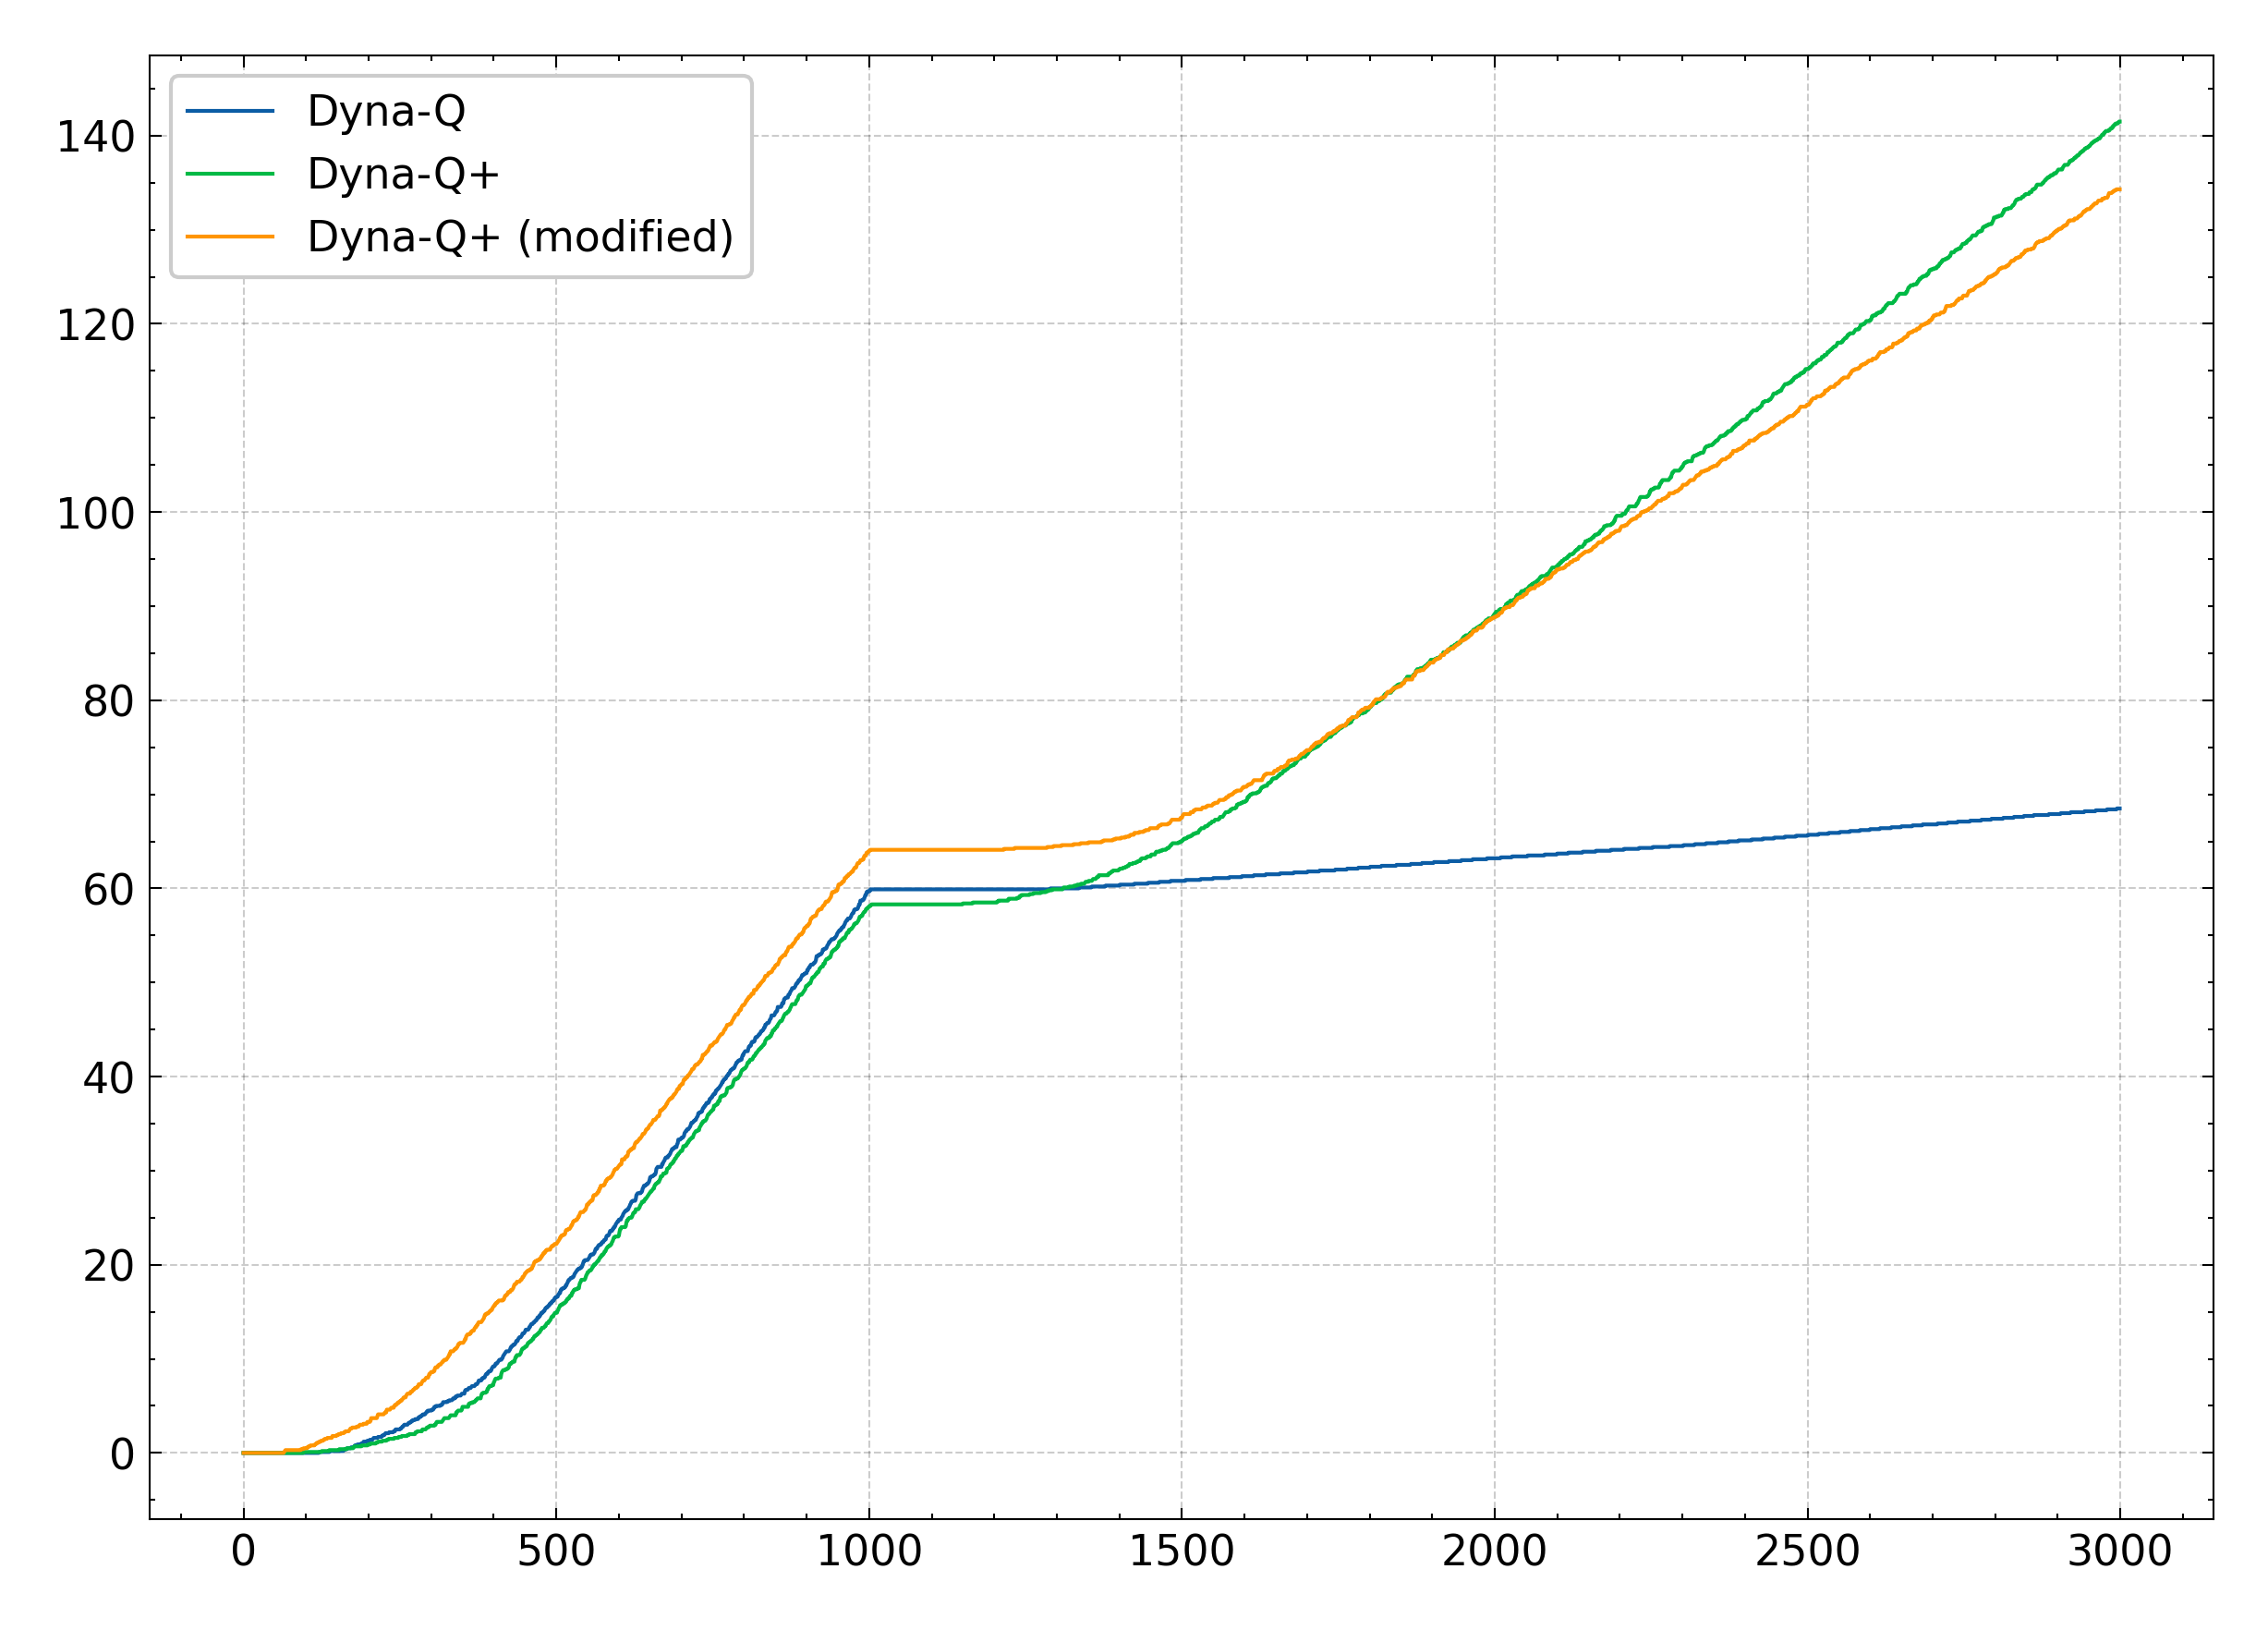

In [14]:
fig, ax = plt.subplots()
ax.plot(R_dyna.T, label="Dyna-Q")
ax.plot(R_dynap.T, label="Dyna-Q+")
ax.plot(R_dynap2.T, label="Dyna-Q+ (modified)")
ax.legend()

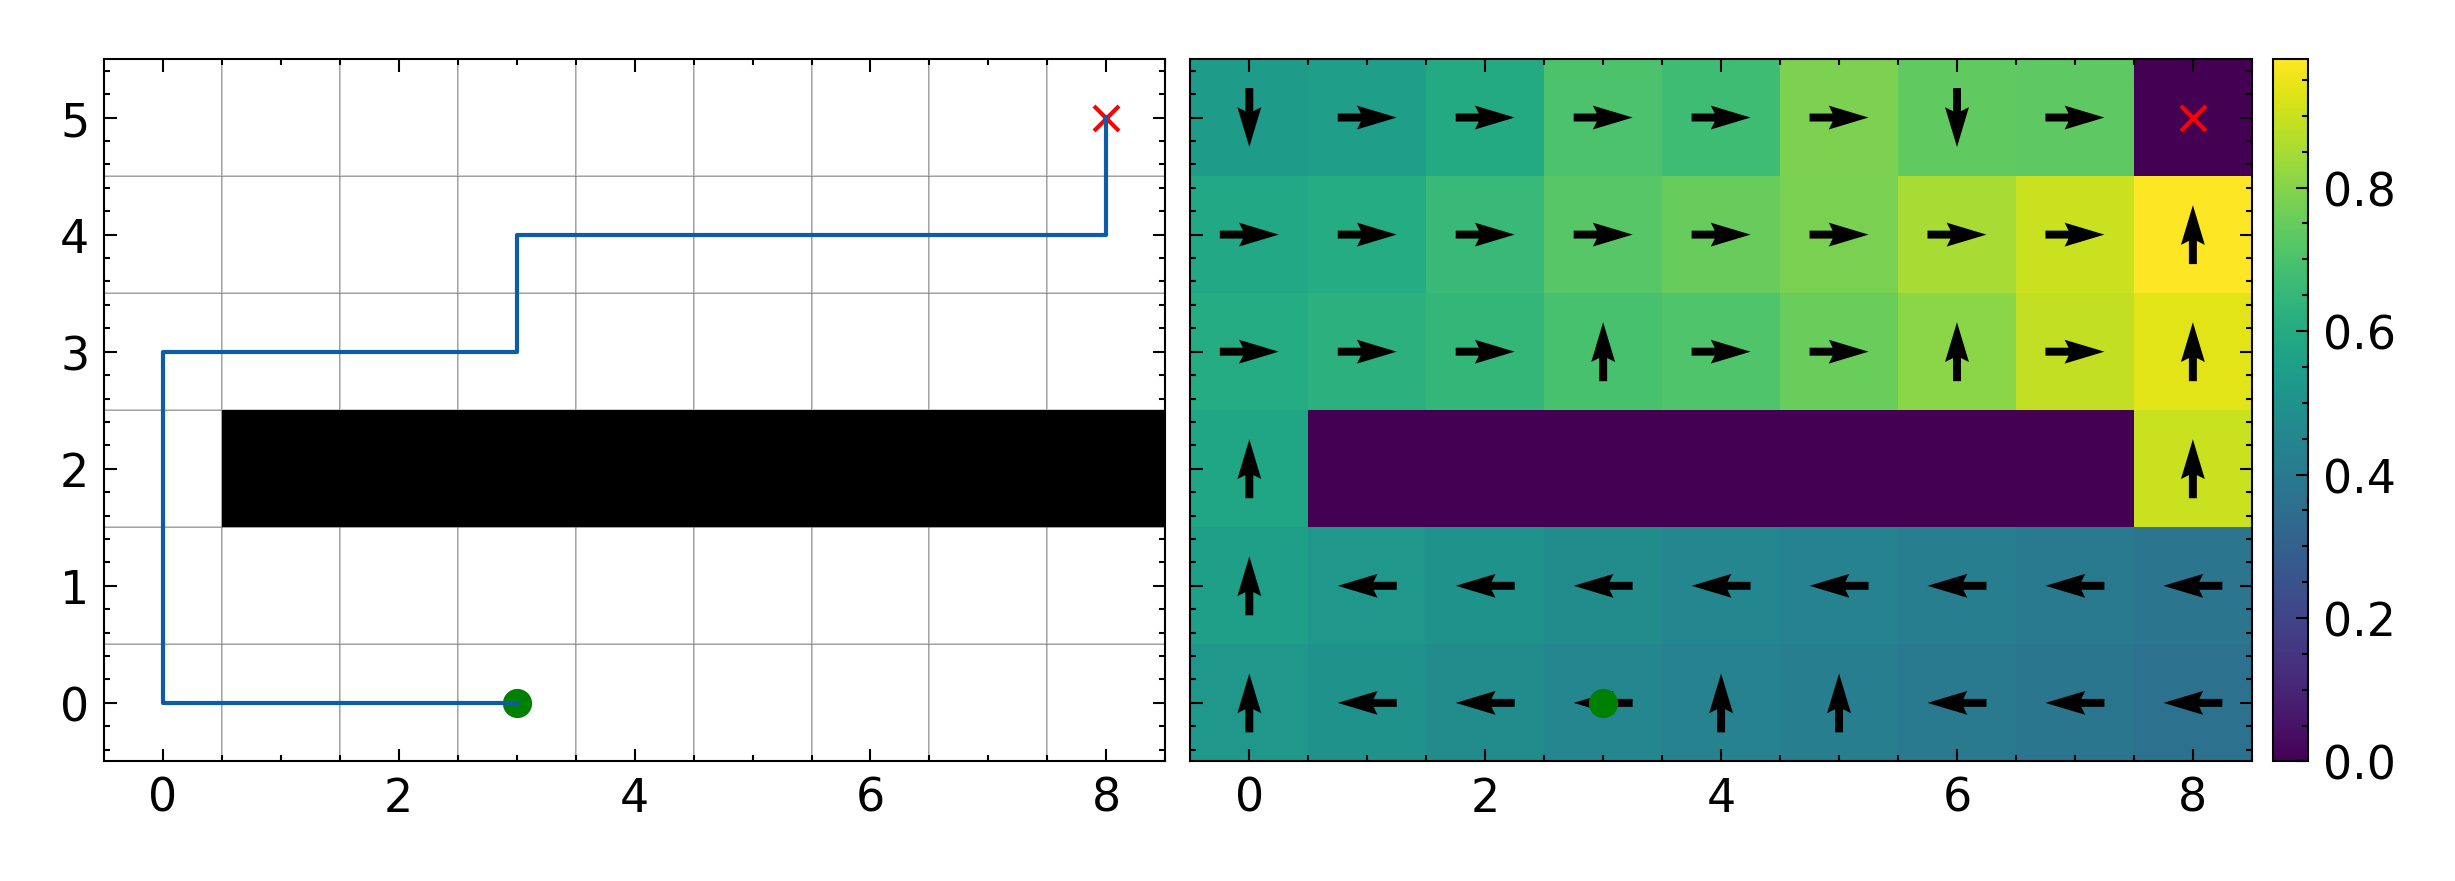

In [15]:
plt.rcParams["axes.axisbelow"] = 'line'
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(W, W/3))
ax[0].pcolormesh(np.arange(grid.shape[1]), np.arange(grid.shape[0]), -grid, cmap='gray',
                 edgecolors=(0, 0, 0, 0.2), linewidth=0.1)
ax[0].plot(start[1], start[0], 'go')
ax[0].plot(goal[1], goal[0], 'rx')
ax[0].grid(False)

# Plot solution
s = start
ep = [s]
while True:
    a = np.argmax(Q_dynap[s])
    s, r = step(s, a)
    ep.append(s)
    if r == 1: break
ep = np.array(ep)
ax[0].plot(ep[:, 1], ep[:, 0])

# Plot value function
I = ax[1].pcolormesh(np.arange(grid.shape[1]), np.arange(grid.shape[0]), Q_dynap.max(-1), cmap='viridis')
fig.colorbar(I, pad=0.02)
ax[1].plot(start[1], start[0], 'go')
ax[1].plot(goal[1], goal[0], 'rx')
ax[1].grid(False)
for x in range(9):
    for y in range(6):
        if Q_dynap[y, x].max() == 0: continue
        a = np.argmax(Q_dynap[y, x])
        u = -1 if a == 3 else 1 if a == 1 else 0
        v = -1 if a == 2 else 1 if a == 0 else 0
        ax[1].quiver([x], [y], [u], [v], pivot='mid')

### Different environment

In [16]:
start = (0, 3)
goal = (5, 8)
N = 6000
M = 2000
n = 50
eps = 0.1
alpha = 0.5
gamma = 0.95

Q_dyna = np.zeros((*grid.shape, 4))
R_dyna = np.zeros(N)
for seed in trange(10):
    grid = np.zeros((6, 9))
    grid[2, 1:] = 1
    rng = np.random.default_rng(seed)
    s = start
    Q = np.zeros((*grid.shape, 4))
    model = {}
    R = np.zeros(N)
    for i in trange(N, leave=False):
        if i == M:
            grid = np.zeros((6, 9))
            grid[2, 1:-1] = 1
        a = rng.choice(np.flatnonzero(Q[s] == Q[s].max()) if rng.uniform() > eps else 4)
        s_, r = step(s, a)
        R[i] = r
        model[(s, a)] = (s_, r)
        Q[s][a] += alpha * (r + gamma*Q[s_].max() - Q[s][a])
        s = s_ if r == 0 else start
        for j in range(n):
            k = rng.choice(len(model.keys()))
            x, u = list(model.keys())[k]
            x_, r = model[(x, u)]
            Q[x][u] += alpha * (r + gamma*Q[x_].max() - Q[x][u])
    R_dyna += np.cumsum(R)
    Q_dyna += Q

R_dyna /= 10
Q_dyna /= 10

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [17]:
kappa = 1e-4

Q_dynap = np.zeros((*grid.shape, 4))
R_dynap = np.zeros(N)
for seed in trange(10):
    grid = np.zeros((6, 9))
    grid[2, 1:] = 1
    rng = np.random.default_rng(seed)
    s = start
    Q = np.zeros((*grid.shape, 4))
    T = np.zeros((*grid.shape, 4))
    model = {}
    R = np.zeros(N)
    for i in trange(N, leave=False):
        if i == M:
            grid = np.zeros((6, 9))
            grid[2, 1:-1] = 1
        a = rng.choice(np.flatnonzero(Q[s] == Q[s].max()) if rng.uniform() > eps else 4)
        s_, r = step(s, a)
        R[i] = r
        T += 1
        T[s][a] = 0
        model[(s, a)] = (s_, r)
        Q[s][a] += alpha * (r + gamma*Q[s_].max() - Q[s][a])
        s = s_ if r == 0 else start
        for j in range(n):
            k = rng.choice(len(model.keys()))
            x, _ = list(model.keys())[k]
            u = rng.choice(4)
            x_, r = model[(x, u)] if (x, u) in model else (x, 0)
            r += kappa * np.sqrt(T[x][u])
            Q[x][u] += alpha * (r + gamma*Q[x_].max() - Q[x][u])
    R_dynap += np.cumsum(R)
    Q_dynap += Q

R_dynap /= 10
Q_dynap /= 10

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [18]:
Q_dynap2 = np.zeros((*grid.shape, 4))
R_dynap2 = np.zeros(N)
for seed in trange(10):
    grid = np.zeros((6, 9))
    grid[2, 1:] = 1
    rng = np.random.default_rng(seed)
    s = start
    Q = np.zeros((*grid.shape, 4))
    T = np.zeros((*grid.shape, 4))
    model = {}
    R = np.zeros(N)
    for i in trange(N, leave=False):
        if i == M:
            grid = np.zeros((6, 9))
            grid[2, 1:-1] = 1
        Qs = Q[s] + kappa*T[s]
        a = rng.choice(np.flatnonzero(Qs == Qs.max()) if rng.uniform() > eps else 4)
        s_, r = step(s, a)
        R[i] = r
        T += 1
        T[s][a] = 0
        model[(s, a)] = (s_, r)
        Q[s][a] += alpha * (r + gamma*Q[s_].max() - Q[s][a])
        s = s_ if r == 0 else start
        for j in range(n):
            k = rng.choice(len(model.keys()))
            x, _ = list(model.keys())[k]
            u = rng.choice(4)
            x_, r = model[(x, u)] if (x, u) in model else (x, 0)
            Q[x][u] += alpha * (r + gamma*Q[x_].max() - Q[x][u])
    R_dynap2 += np.cumsum(R)
    Q_dynap2 += Q

R_dynap2 /= 10
Q_dynap2 /= 10

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

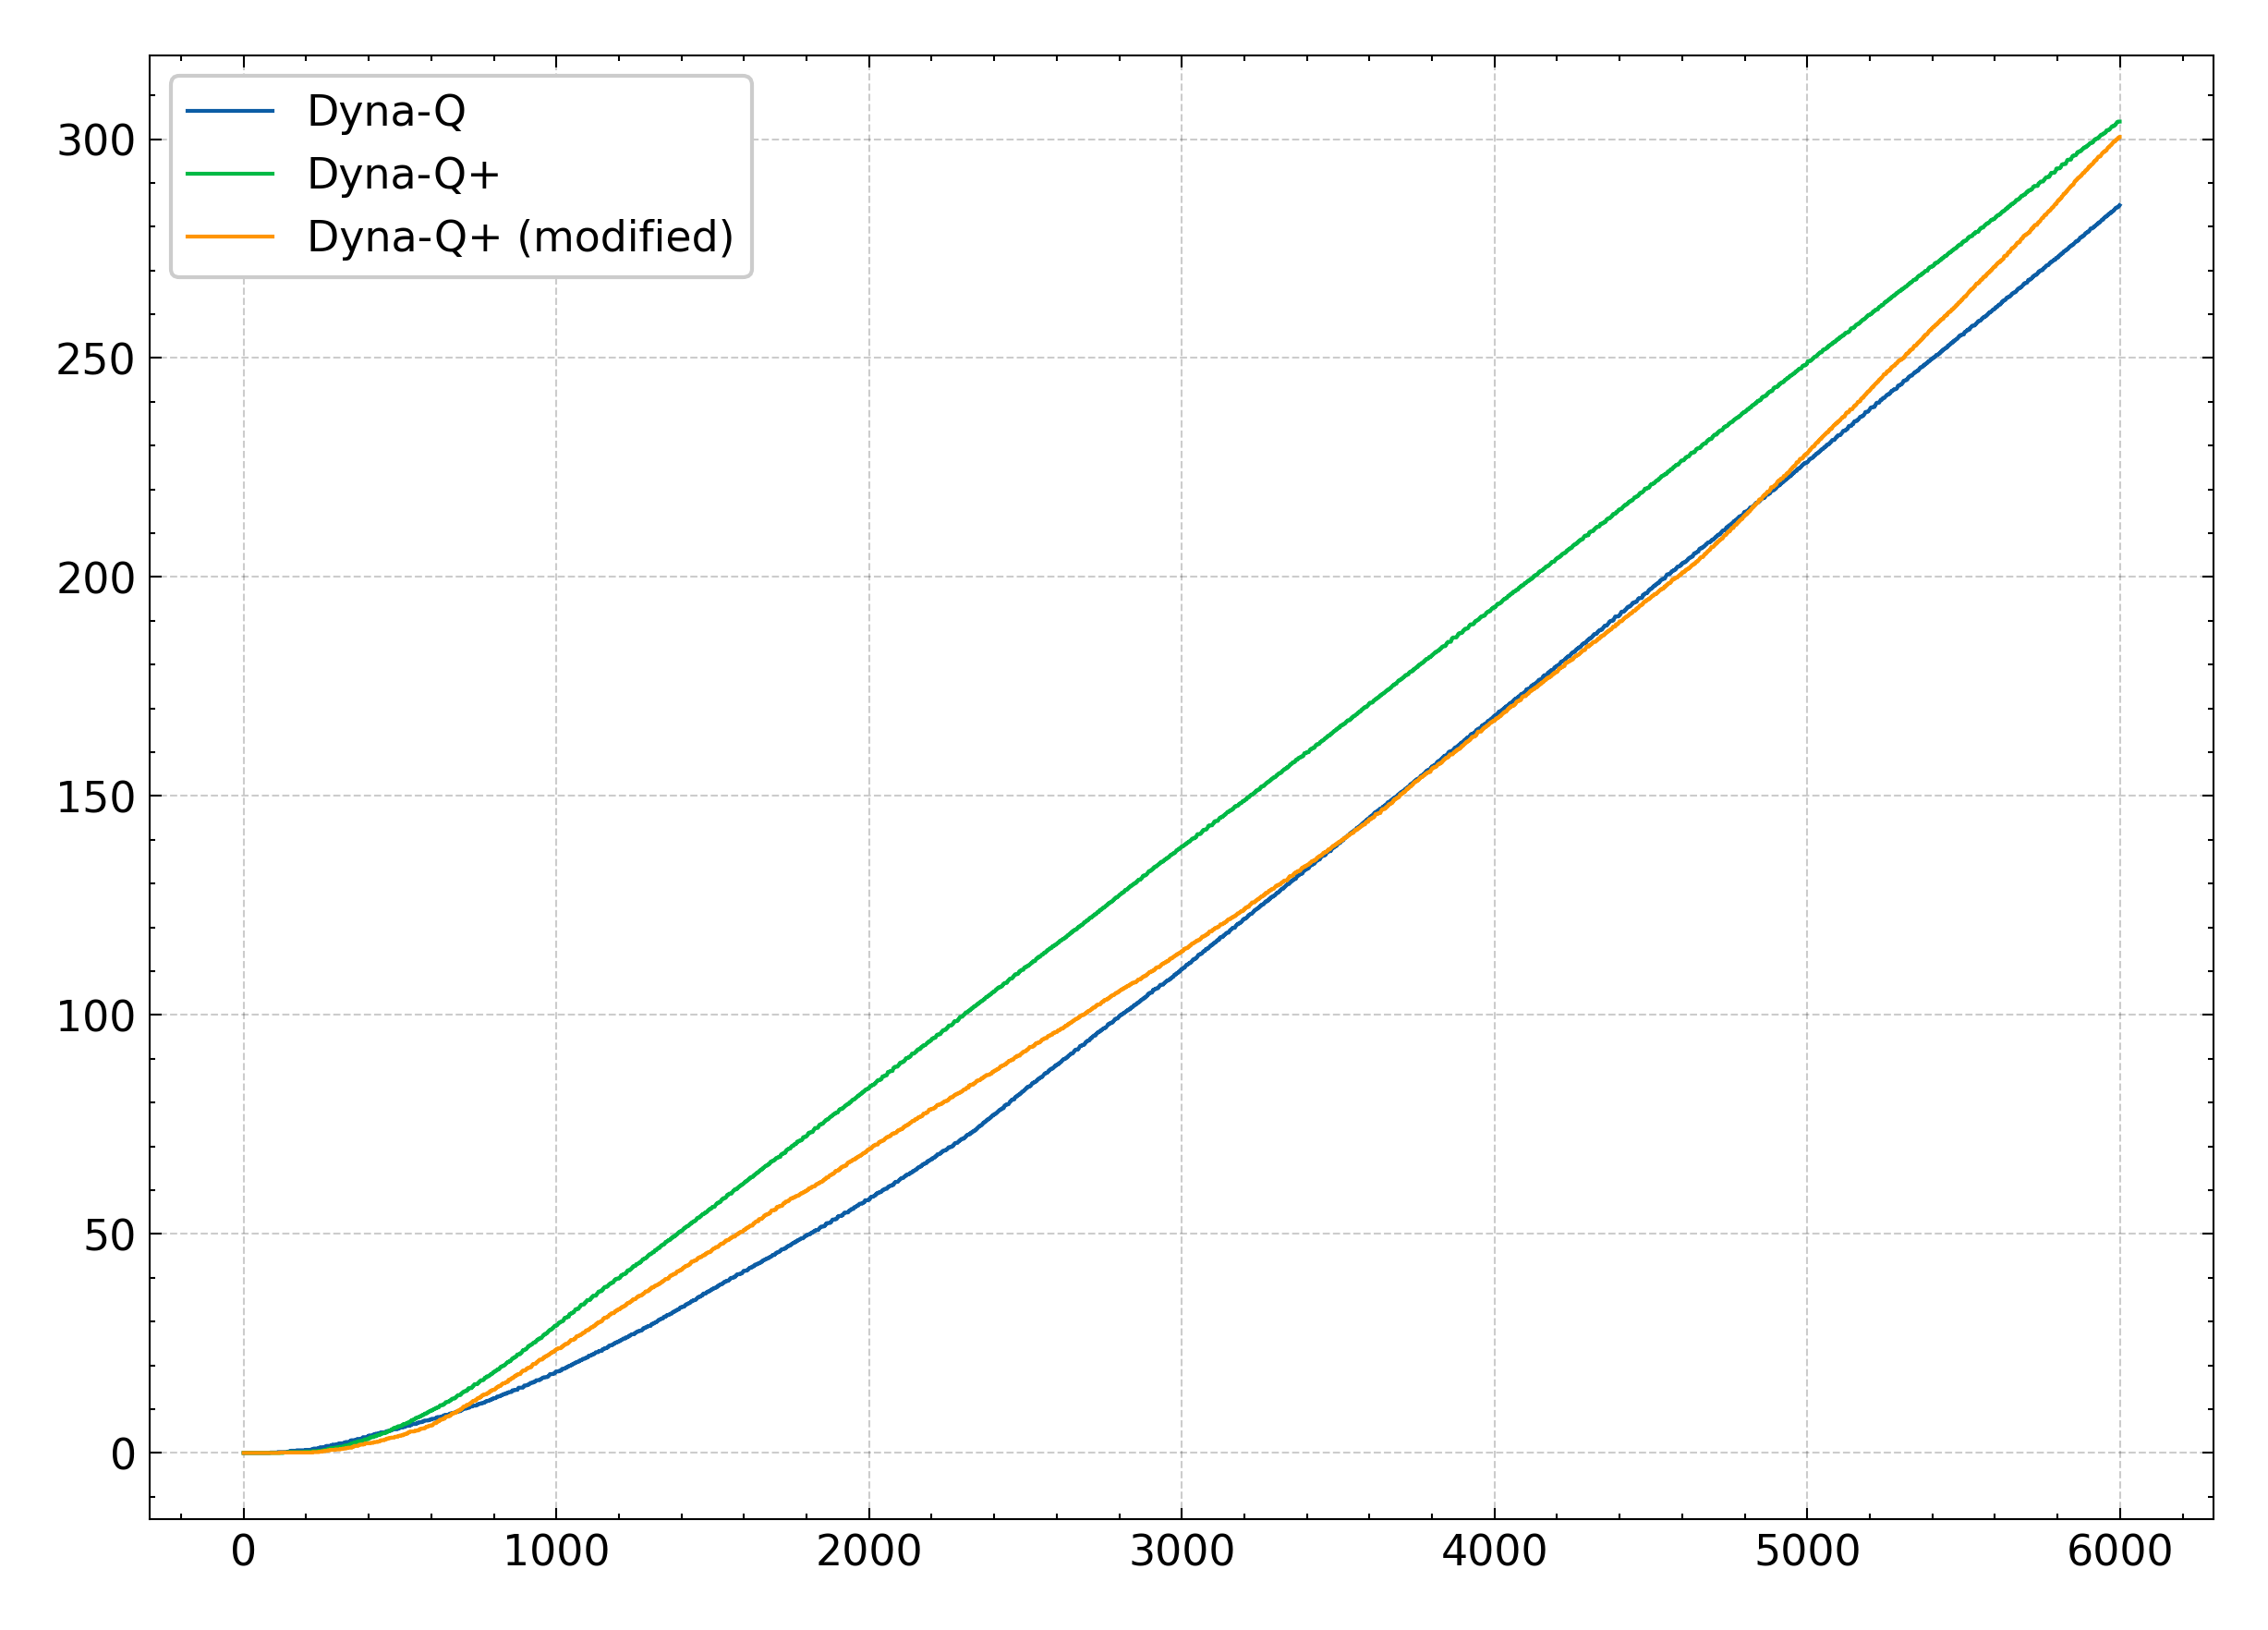

In [19]:
fig, ax = plt.subplots()
ax.plot(R_dyna.T, label="Dyna-Q")
ax.plot(R_dynap.T, label="Dyna-Q+")
ax.plot(R_dynap2.T, label="Dyna-Q+ (modified)")
ax.legend()

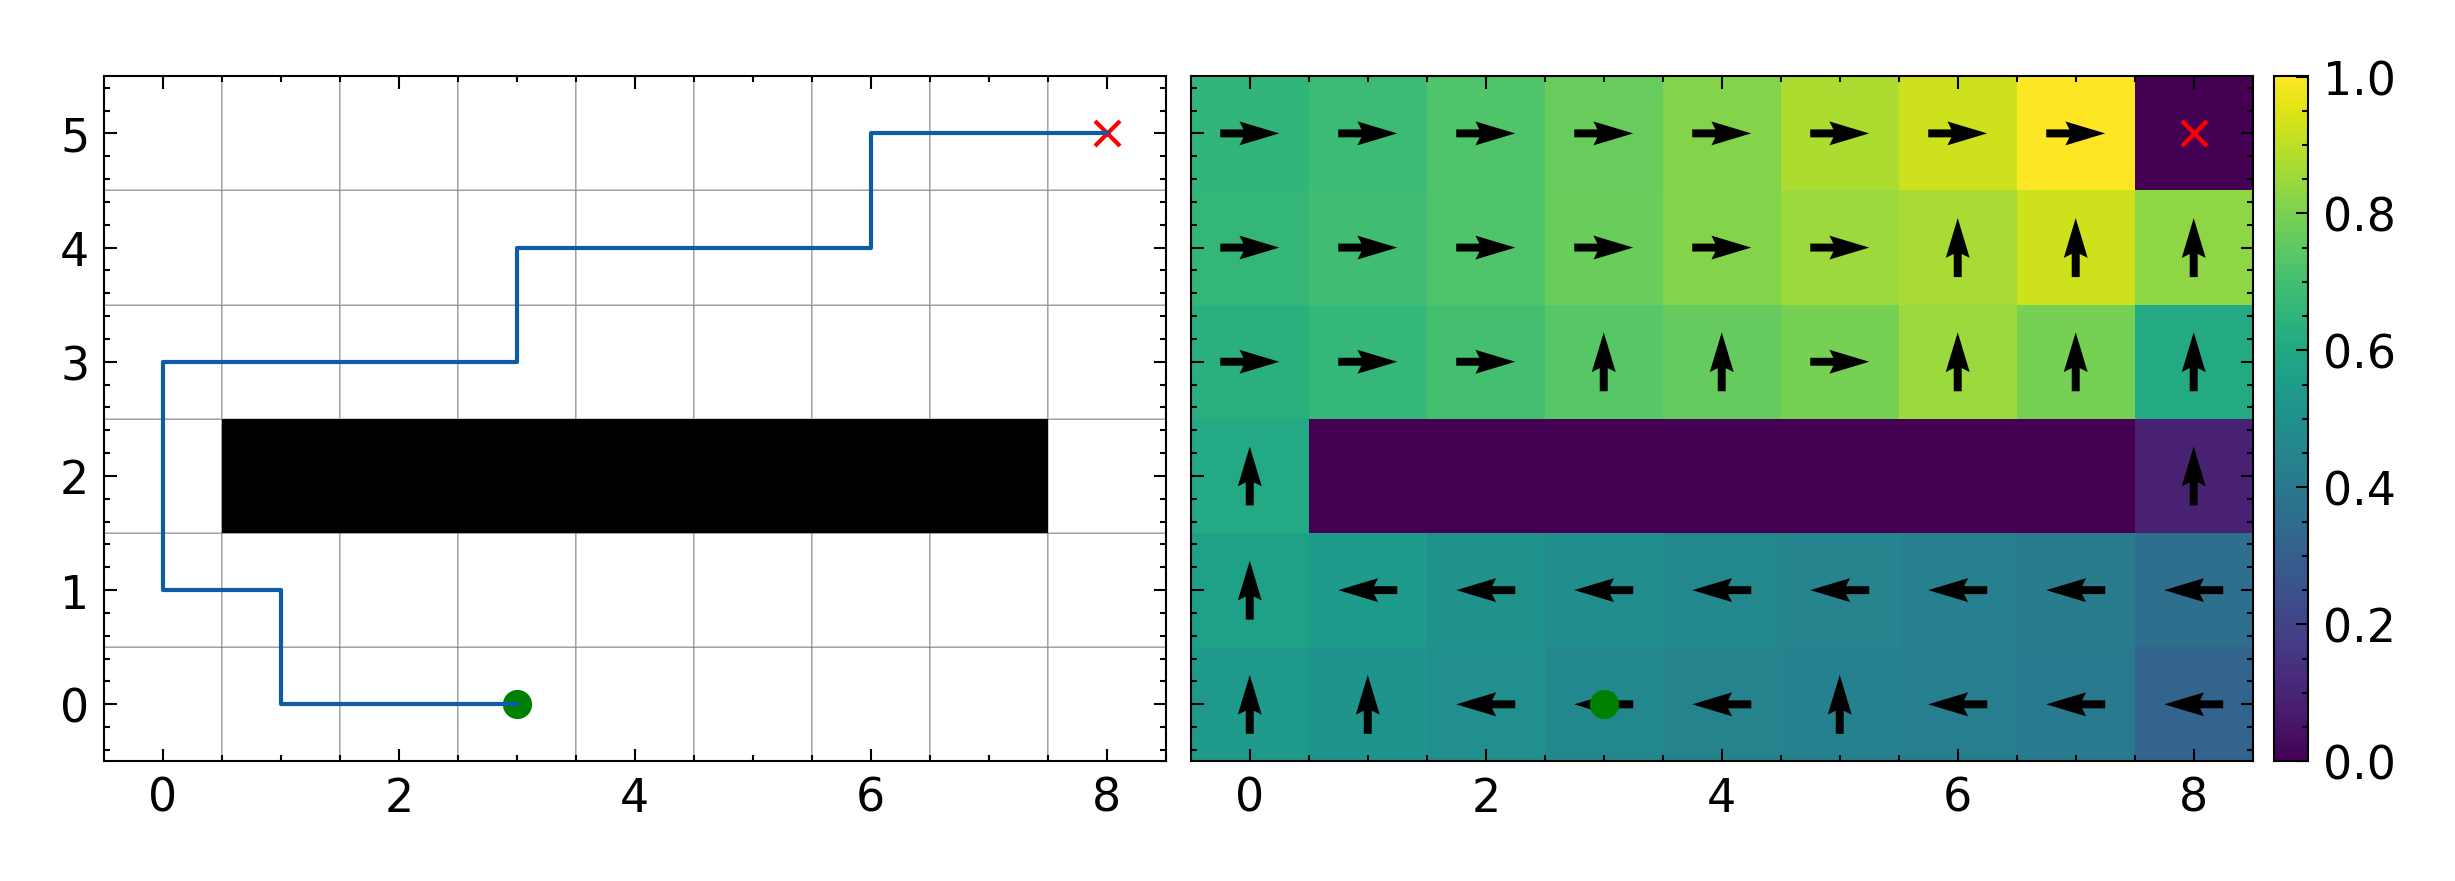

In [20]:
plt.rcParams["axes.axisbelow"] = 'line'
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(W, W/3))
ax[0].pcolormesh(np.arange(grid.shape[1]), np.arange(grid.shape[0]), -grid, cmap='gray',
                 edgecolors=(0, 0, 0, 0.2), linewidth=0.1)
ax[0].plot(start[1], start[0], 'go')
ax[0].plot(goal[1], goal[0], 'rx')
ax[0].grid(False)

# Plot solution
s = start
ep = [s]
while True:
    a = np.argmax(Q_dynap[s])
    s, r = step(s, a)
    ep.append(s)
    if r == 1: break
ep = np.array(ep)
ax[0].plot(ep[:, 1], ep[:, 0])

# Plot value function
I = ax[1].pcolormesh(np.arange(grid.shape[1]), np.arange(grid.shape[0]), Q_dynap.max(-1), cmap='viridis')
fig.colorbar(I, pad=0.02)
ax[1].plot(start[1], start[0], 'go')
ax[1].plot(goal[1], goal[0], 'rx')
ax[1].grid(False)
for x in range(9):
    for y in range(6):
        if Q_dynap[y, x].max() == 0: continue
        a = np.argmax(Q_dynap[y, x])
        u = -1 if a == 3 else 1 if a == 1 else 0
        v = -1 if a == 2 else 1 if a == 0 else 0
        ax[1].quiver([x], [y], [u], [v], pivot='mid')

---
# Exercise 8.8

In [47]:
S = 1000
values = []
for b in [1, 3, 10]:
    vs = []
    for i in trange(200):
        vs.append([])
        rng = np.random.default_rng(i)
        T = rng.integers(S, size=(S, 2, b))
        R = rng.standard_normal((S, 2, b))
        Q = np.zeros((S, 2))

        for j in range(10):
            # Update value function
            for s in range(S):
                for a in range(2):
                    Q[s, a] = 0.9/b * sum(R[s, a, k] + Q[x].max() for k, x in enumerate(T[s, a]))

                if s % 100 == 0:
                    # Evaluate current policy
                    vs[-1].append(0)
                    for _ in range(50):
                        v = 0
                        s = 0
                        while True:
                            a = np.argmax(Q[s])
                            if rng.uniform() < 0.1:
                                break
                            k = rng.choice(b)
                            s = T[s, a, k]
                            v += R[s, a, k]
                        vs[-1][-1] += v
                    vs[-1][-1] /= 50

    values.append(np.array(vs).mean(0))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [53]:
%%julia
using Random
using ProgressBars

function plan_uniform(S, b)
    vs = []
    for i = tqdm(1:1000)
        append!(vs, [[]])
        rng = Xoshiro(i)
        T = rand(rng, 1:S, S, 2, b)
        R = randn(rng, S, 2, b)
        Q = zeros(S, 2)

        for j = 1:10
            # Update value function
            for s = 1:S
                for a = 1:2
                    Q[s, a] = 0.9/b * sum(R[s, a, k] + maximum(Q[x, :]) for (k, x) in enumerate(T[s, a, :]))
                end

                if (s - 1) % 50 == 0
                    # Evaluate current policy
                    append!(vs[end], 0)
                    for _ = 1:100
                        v = 0
                        s = 1
                        while true
                            a = argmax(Q[s, :])
                            if rand(rng) < 0.1
                                break
                            end
                            k = rand(rng, 1:b)
                            v += R[s, a, k]
                            s = T[s, a, k]
                        end
                        vs[end][end] += v
                    end
                    vs[end][end] /= 100
                end
            end
        end
    end
    return vs
end

function plan_onpolicy(S, b)
    vs = []
    for i = tqdm(1:1000)
        append!(vs, [[]])
        rng = Xoshiro(i)
        T = rand(rng, 1:S, S, 2, b)
        R = randn(rng, S, 2, b)
        Q = zeros(S, 2)

        s = 1
        for j = 1:(10 * S * 2)
            # Update value function
            a = rand(rng) >= 0.1 ? argmax(Q[s, :]) : rand(rng, 1:2)
            Q[s, a] = 0.9/b * sum(R[s, a, k] + maximum(Q[x, :]) for (k, x) in enumerate(T[s, a, :]))
            s = rand(rng) >= 0.1 ? T[s, a, rand(rng, 1:b)] : 1

            if (j - 1) % 100 == 0
                # Evaluate current policy
                append!(vs[end], 0)
                for _ = 1:100
                    v = 0
                    x = 1
                    while true
                        u = argmax(Q[x, :])
                        if rand(rng) < 0.1
                            break
                        end
                        k = rand(rng, 1:b)
                        v += R[x, u, k]
                        x = T[x, u, k]
                    end
                    vs[end][end] += v
                end
                vs[end][end] /= 100
            end
        end
    end
    return vs
end

<PyCall.jlwrap plan_onpolicy>

In [ ]:
vs_u = np.array([np.array(Main.plan_uniform(1000, b)).mean(0) for b in [1, 3, 10]])
vs_op = np.array([np.array(Main.plan_onpolicy(1000, b)).mean(0) for b in [1, 3, 10]])

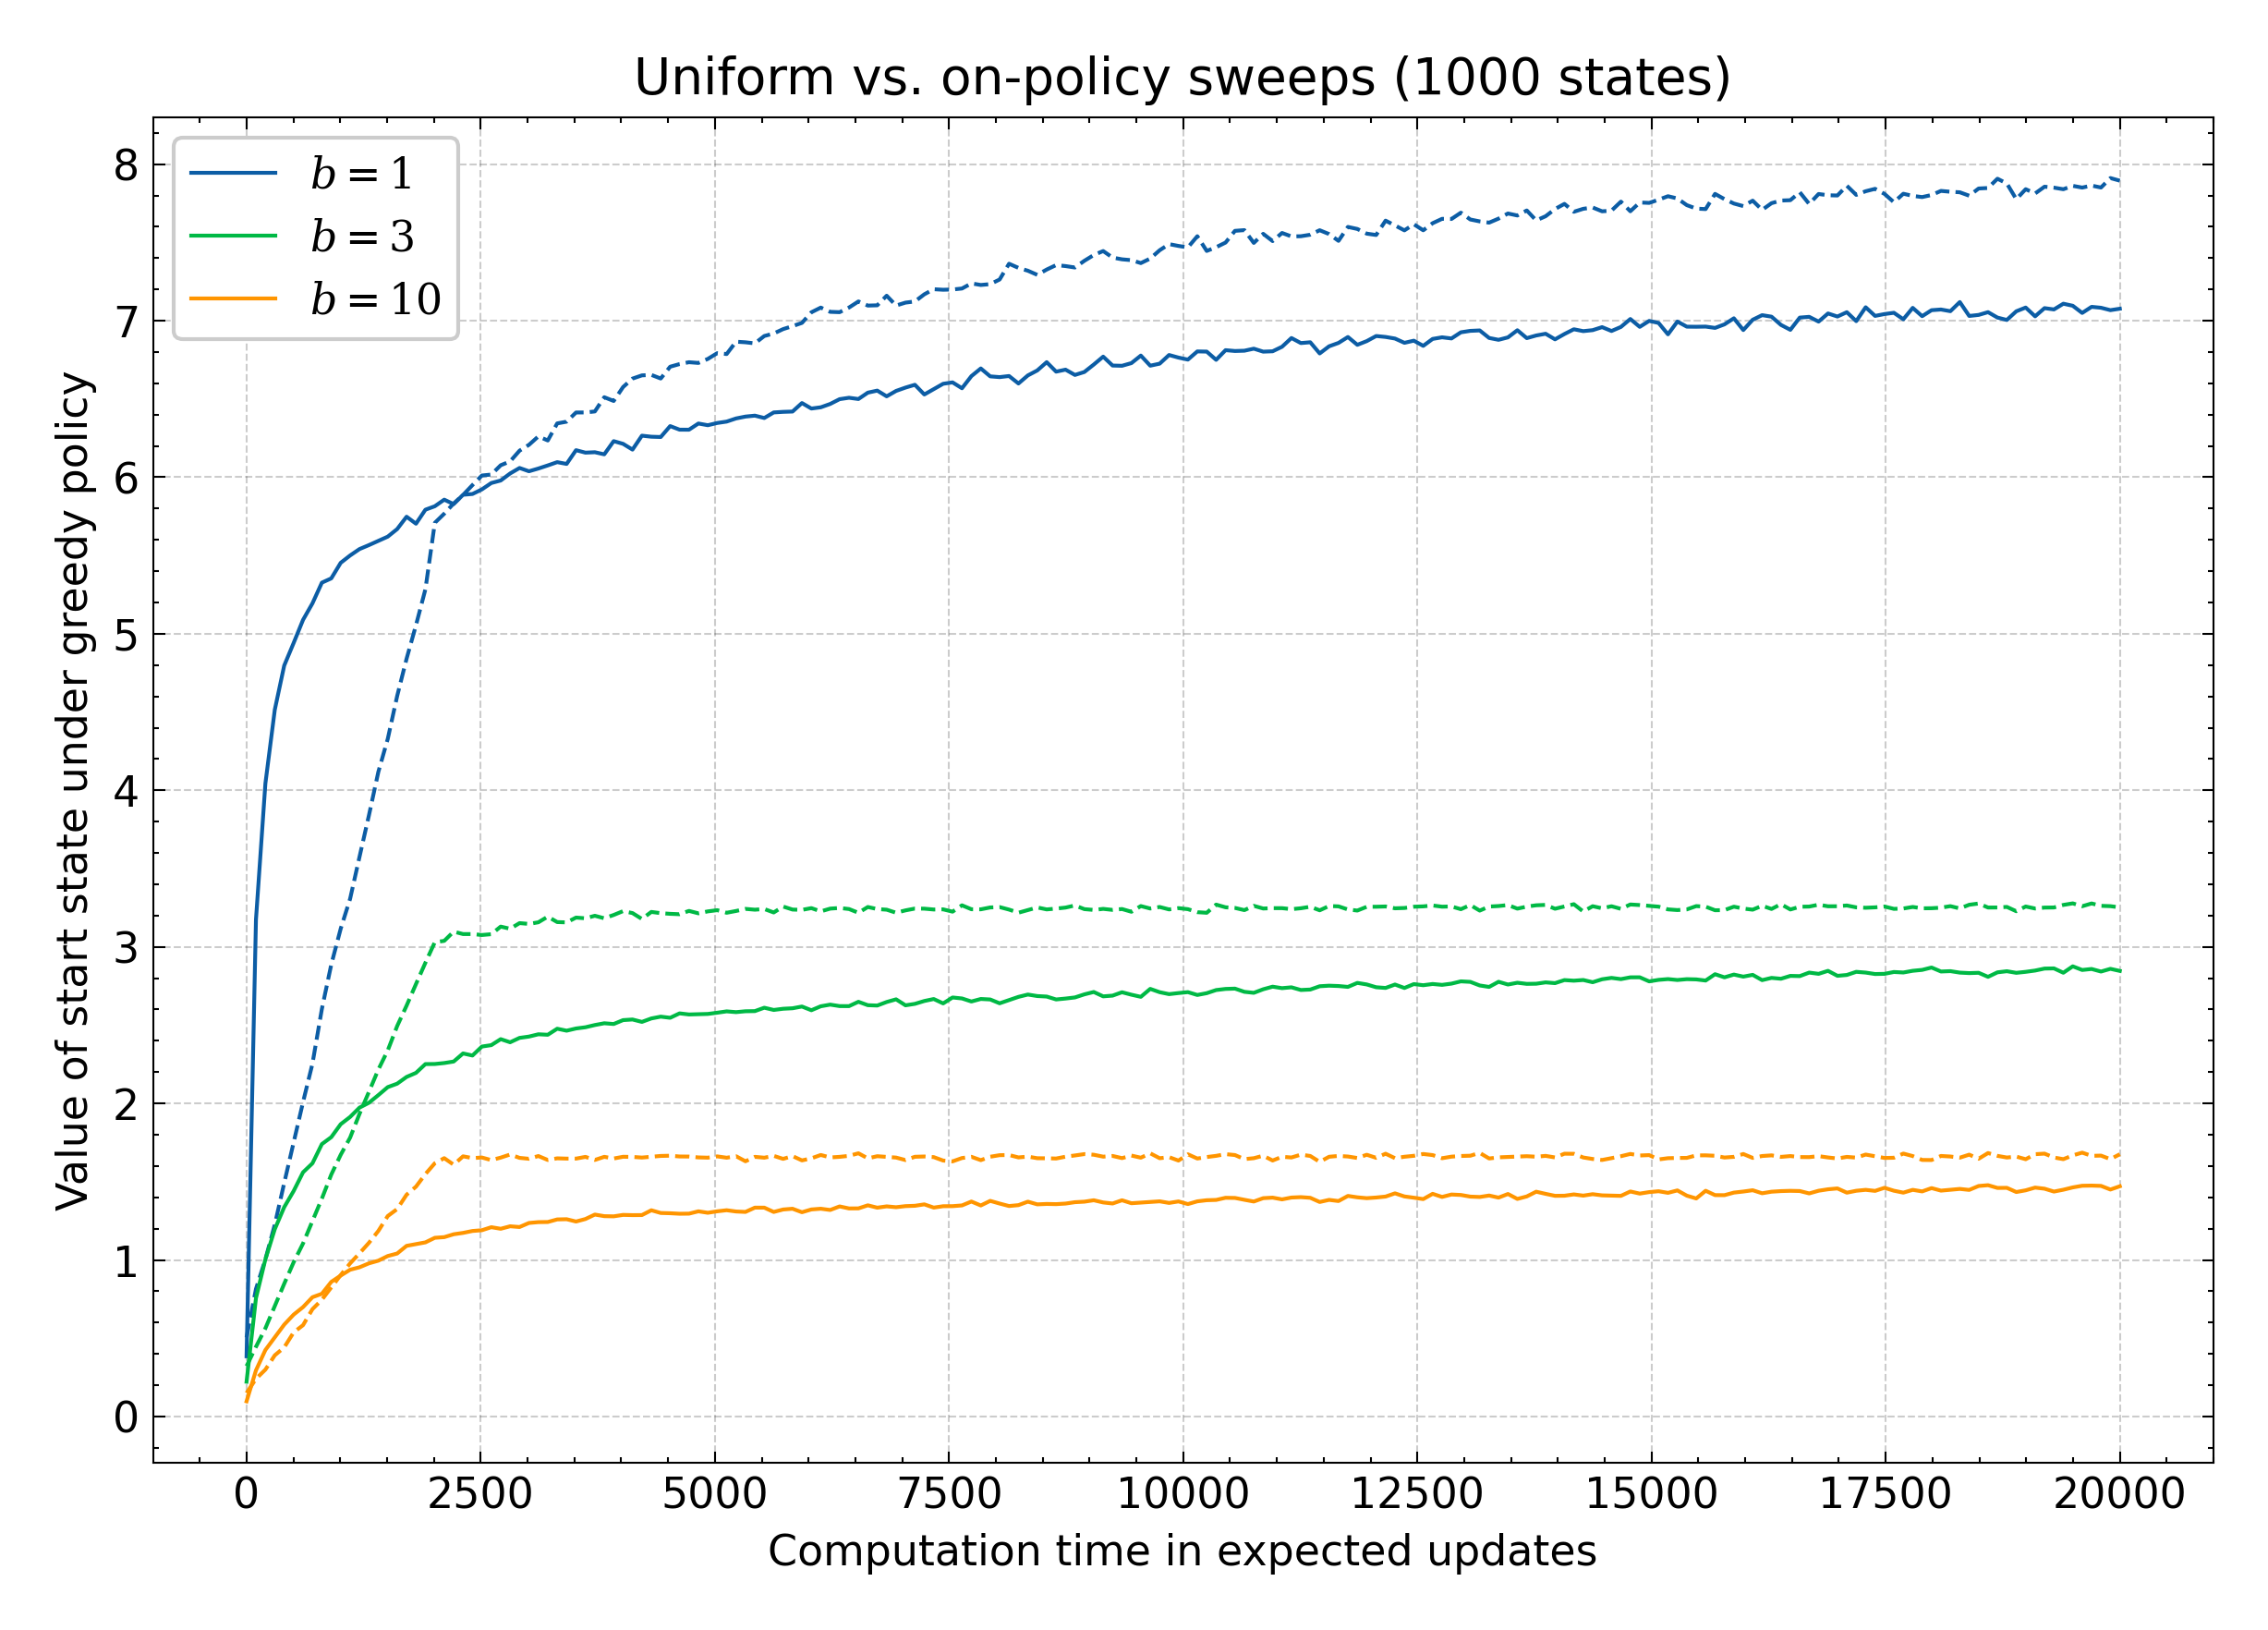

In [59]:
fig, ax = plt.subplots()
ax.set_title("Uniform vs. on-policy sweeps (1000 states)")
ax.set_xlabel("Computation time in expected updates")
ax.set_ylabel("Value of start state under greedy policy")
for i, b in enumerate([1, 3, 10]):
    ax.plot(np.linspace(0, 1000 * 2 * 10, len(vs_op[i])), vs_op[i], f'C{i}', label=f"$b = {b}$")
    ax.plot(np.linspace(0, 1000 * 2 * 10, len(vs_op[i])), vs_u[i], f'C{i}--')
ax.legend()

In [ ]:
vs_u = np.array([np.array(Main.plan_uniform(10_000, b)).mean(0) for b in [1, 3]])
vs_op = np.array([np.array(Main.plan_onpolicy(10_000, b)).mean(0) for b in [1, 3]])

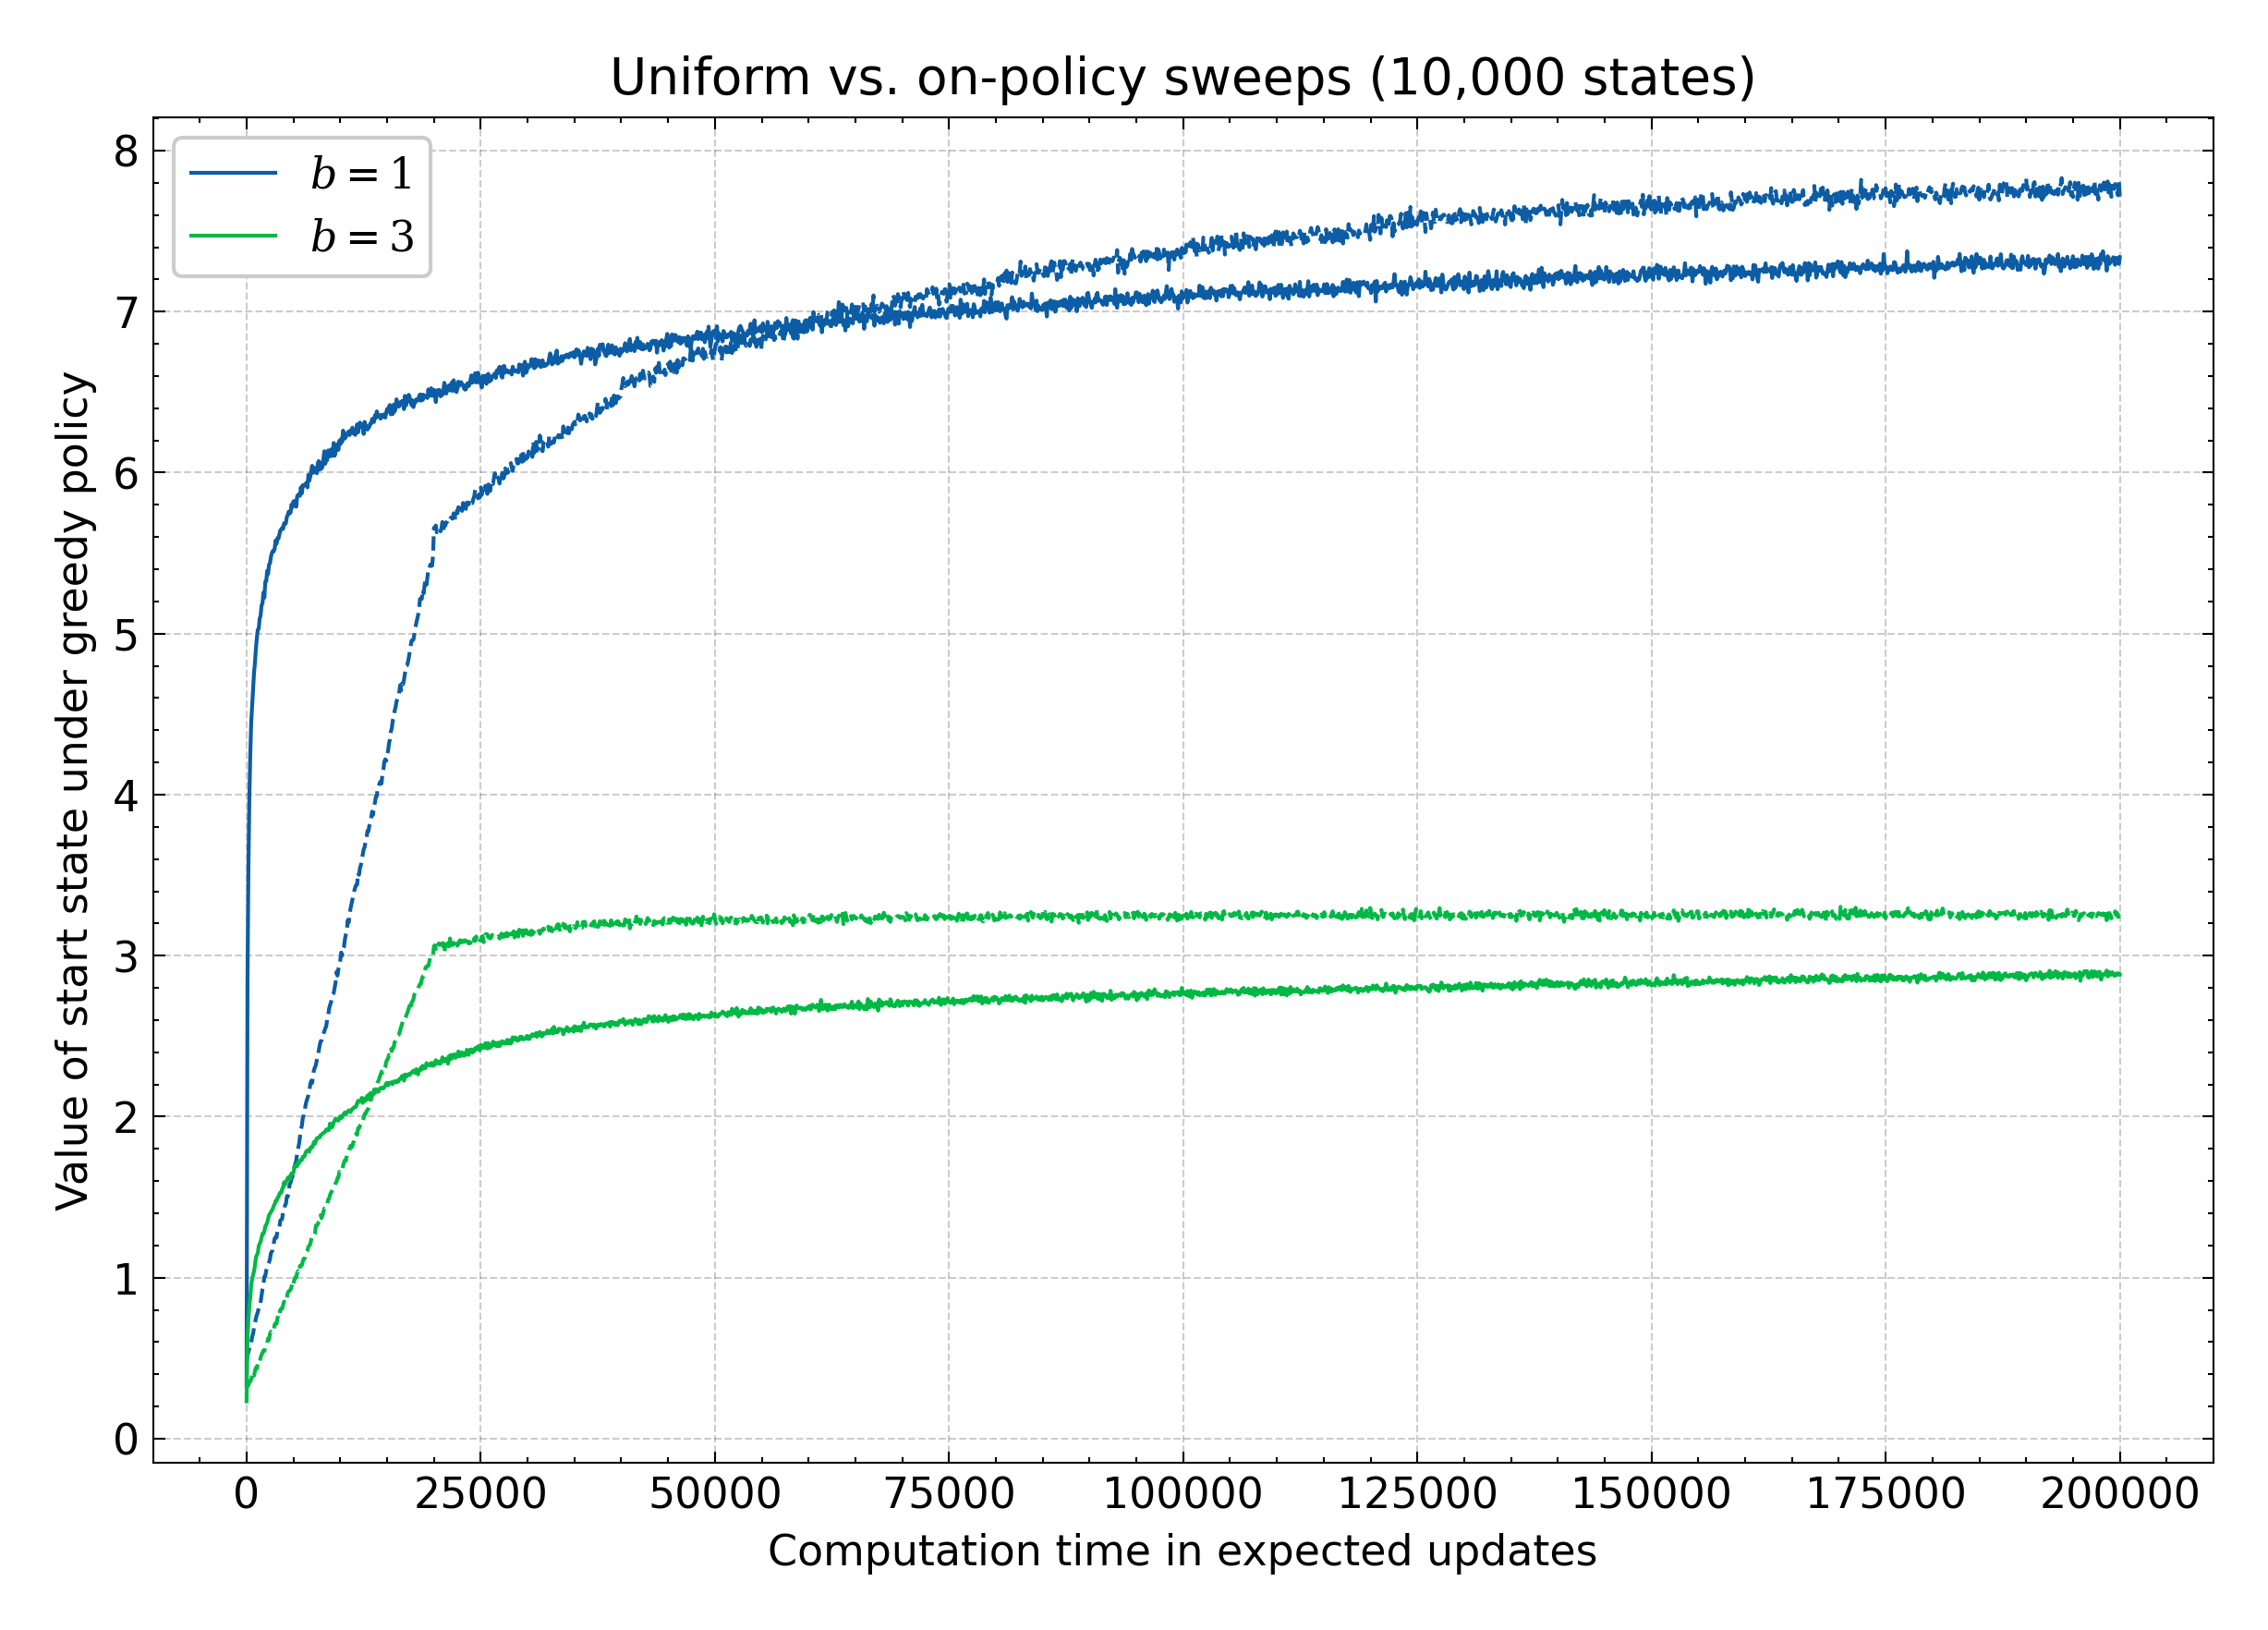

In [61]:
fig, ax = plt.subplots()
ax.set_title("Uniform vs. on-policy sweeps (10,000 states)")
ax.set_xlabel("Computation time in expected updates")
ax.set_ylabel("Value of start state under greedy policy")
for i, b in enumerate([1, 3]):
    ax.plot(np.linspace(0, 10000 * 2 * 10, len(vs_op[i])), vs_op[i], f'C{i}', label=f"$b = {b}$")
    ax.plot(np.linspace(0, 10000 * 2 * 10, len(vs_op[i])), vs_u[i], f'C{i}--')
ax.legend()

I don't get the same curves as in the book (p. 176). However, the linear trends at the beginning with the uniform sweeping make even more sense to me than the "scalloping" seen in the book..